# NIH Chest X-Ray — Local EDA


This notebook performs EDA on the **local** NIH ChestX-ray14 dataset.  
It **requires** the real metadata CSV to be present and will stop with a clear error if not found.


## 0) Configuration

In [15]:

DATA_DIR = r"C:\Springboard\Data Science at Scale\23.5 Capstone 3 - Project Proposals\Thoracic"   
CSV_NAME = "Data_Entry_2017.csv"    

METADATA_CSV_CANDIDATES = [
    "Data_Entry_2017.csv",
    "Data_Entry_2017_v2020.csv",
    "train.csv"
]

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 160)

def resolve_metadata_path(base_dir, csv_name=None, candidates=None):
    if csv_name:
        path = os.path.join(base_dir, csv_name)
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Could not find CSV at {path}. Please verify DATA_DIR/CSV_NAME.")
        return path
    for name in (candidates or []):
        path = os.path.join(base_dir, name)
        if os.path.isfile(path):
            return path
    raise FileNotFoundError(
        "NIH metadata CSV not found. Looked for: "
        + ", ".join([os.path.join(base_dir, c) for c in (candidates or [])])
        + ". Set CSV_NAME if your file is named differently."
    )

METADATA_PATH = resolve_metadata_path(DATA_DIR, CSV_NAME, METADATA_CSV_CANDIDATES)
print("Using metadata:", METADATA_PATH)


Using metadata: C:\Springboard\Data Science at Scale\23.5 Capstone 3 - Project Proposals\Thoracic\Data_Entry_2017.csv


## 1) Load metadata

In [16]:

raw_df = pd.read_csv(METADATA_PATH)
print(f"Loaded rows: {len(raw_df):,}")
raw_df.head()


Loaded rows: 112,120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


## 2) Organize schema (clean names, ensure types)

In [17]:

df = raw_df.copy()

df.columns = (
    df.columns.str.strip()
             .str.replace(" ", "_")
             .str.replace(r"\[", "", regex=True)
             .str.replace(r"\]", "", regex=True)
             .str.replace("/", "_", regex=False)
             .str.lower()
)

df.rename(columns={
    "height": "originalimage_height",
    "originalimagewidth": "originalimage_width",
    "originalimagepixelspacingx": "originalimagepixelspacing_x",
    "y": "originalimagepixelspacing_y",
    "finding_labels": "finding_labels",
    "follow-up_#": "follow_up"
}, inplace=True)

expected_cols = [
    "image_index","finding_labels","follow_up","patient_id","patient_age",
    "patient_gender","view_position","originalimage_width","originalimage_height",
    "originalimagepixelspacing_x","originalimagepixelspacing_y"
]
for c in expected_cols:
    if c not in df.columns:
        df[c] = np.nan

df["patient_id"] = pd.to_numeric(df["patient_id"], errors="coerce").astype("Int64")
df["patient_age"] = pd.to_numeric(df["patient_age"], errors="coerce").astype("Float64")
df["follow_up"] = pd.to_numeric(df["follow_up"], errors="coerce").astype("Int64")

df.head()


,image_index,finding_labels,follow_up,patient_id,patient_age,patient_gender,view_position,originalimage_width,originalimage_height,originalimagepixelspacing_x,originalimagepixelspacing_y,unnamed:_11
0,00000001_000.png,Cardiomegaly,0,1,58.0,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58.0,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58.0,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81.0,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81.0,F,PA,2582,2991,0.143,0.143,NaN


## 3) Expand multi-label targets

In [18]:

LABELS = [
    "Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion",
    "Emphysema","Fibrosis","Hernia","Infiltration","Mass",
    "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax"
]

def split_labels(val):
    if pd.isna(val):
        return []
    s = str(val).strip()
    if s == "" or s.lower() == "no finding":
        return []
    return [x.strip().replace(" ", "_") for x in s.split("|")]

df["labels_list"] = df["finding_labels"].apply(split_labels)
for lab in LABELS:
    df[f"label_{lab}"] = df["labels_list"].apply(lambda xs: 1 if lab in xs else 0)

df["label_count"] = df[[f"label_{l}" for l in LABELS]].sum(axis=1)
df[["image_index","finding_labels","label_count"]].head()


,image_index,finding_labels,label_count
0,00000001_000.png,Cardiomegaly,1
1,00000001_001.png,Cardiomegaly|Emphysema,2
2,00000001_002.png,Cardiomegaly|Effusion,2
3,00000002_000.png,No Finding,0
4,00000003_000.png,Hernia,1


## 4) Missing values & standardization

In [19]:

missing = df.isna().sum().sort_values(ascending=False).to_frame("missing_count")
missing["missing_pct"] = (missing["missing_count"] / len(df) * 100).round(2)
missing.head(20)


,missing_count,missing_pct
unnamed:_11,112120,100.0
image_index,0,0.0
follow_up,0,0.0
finding_labels,0,0.0
patient_id,0,0.0
patient_age,0,0.0
view_position,0,0.0
patient_gender,0,0.0
originalimage_width,0,0.0
originalimage_height,0,0.0


In [20]:

df["patient_age"] = df["patient_age"].mask((df["patient_age"] < 0) | (df["patient_age"] > 120), np.nan).astype("Float64")
df["patient_gender"] = df["patient_gender"].where(df["patient_gender"].isin(["M","F"]), np.nan)
df["view_position"] = df["view_position"].astype("string").str.upper()
df["view_position"] = df["view_position"].where(df["view_position"].isin(["PA","AP"]), np.nan)
df[["patient_age","patient_gender","view_position"]].head()


,patient_age,patient_gender,view_position
0,58.0,M,PA
1,58.0,M,PA
2,58.0,M,PA
3,81.0,M,PA
4,81.0,F,PA


## 5) Duplicates

In [21]:

before = len(df)
df = df.drop_duplicates(subset=["image_index"], keep="first")
after = len(df)
print(f"Duplicate images removed: {before - after}")

dup_mask = df.duplicated(subset=["patient_id","follow_up"], keep=False)
dup_table = df.loc[dup_mask, ["image_index","patient_id","follow_up"]].sort_values(["patient_id","follow_up"])
dup_table.head(10)


Duplicate images removed: 0


,image_index,patient_id,follow_up


## 6) Label frequency

In [22]:

label_cols = [f"label_{l}" for l in LABELS]
label_counts = df[label_cols].sum().sort_values(ascending=False)
label_counts.to_frame("count")


,count
label_Infiltration,19894
label_Effusion,13317
label_Atelectasis,11559
label_Nodule,6331
label_Mass,5782
label_Pneumothorax,5302
label_Consolidation,4667
label_Pleural_Thickening,3385
label_Cardiomegaly,2776
label_Emphysema,2516


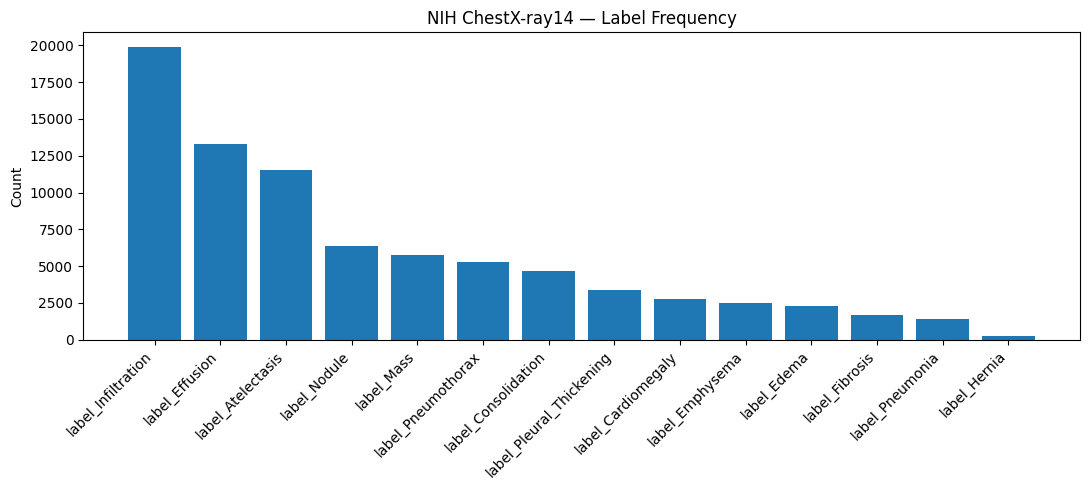

In [23]:

plt.figure(figsize=(11,5))
plt.bar(label_counts.index, label_counts.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.title("NIH ChestX-ray14 — Label Frequency")
plt.tight_layout()
plt.show()


## 7) Label co-occurrence

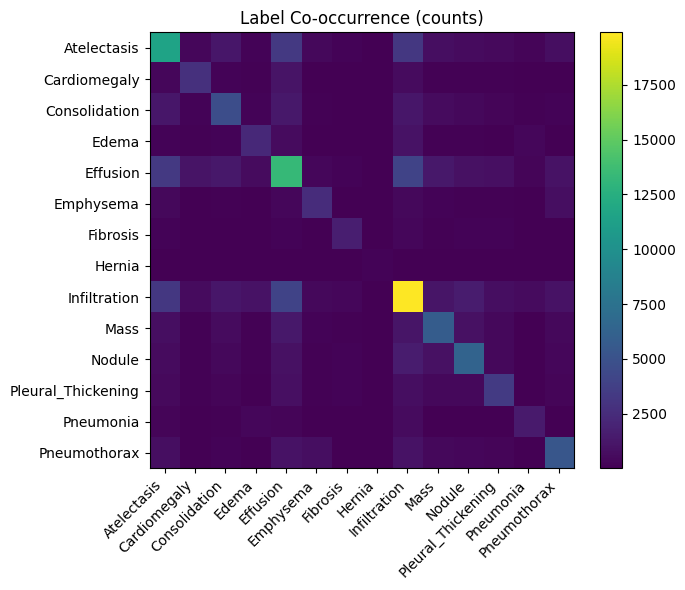

In [24]:

co_mat = np.zeros((len(LABELS), len(LABELS)), dtype=int)
for i, a in enumerate(LABELS):
    for j, b in enumerate(LABELS):
        if i <= j:
            both = (df[f"label_{a}"] & df[f"label_{b}"]).sum()
            co_mat[i, j] = both
            co_mat[j, i] = both

plt.figure(figsize=(7,6))
plt.imshow(co_mat, interpolation="nearest", aspect="auto")
plt.xticks(ticks=range(len(LABELS)), labels=LABELS, rotation=45, ha="right")
plt.yticks(ticks=range(len(LABELS)), labels=LABELS)
plt.title("Label Co-occurrence (counts)")
plt.colorbar()
plt.tight_layout()
plt.show()


## 8) Patient distributions

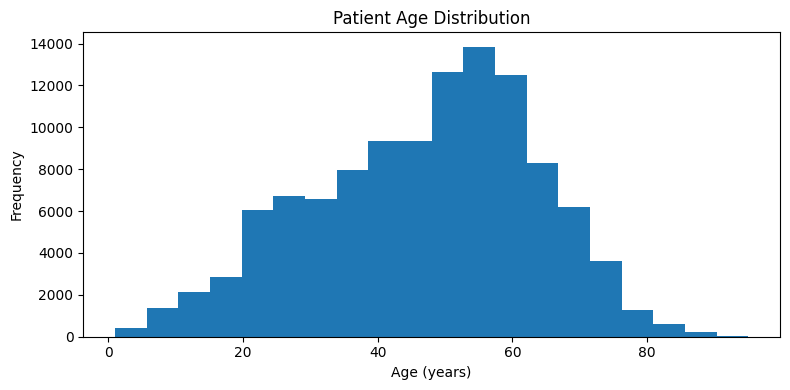

,count
view_position,
PA,67310
AP,44810


In [25]:

# Age histogram
if df["patient_age"].notna().any():
    plt.figure(figsize=(8,4))
    df["patient_age"].dropna().astype(float).plot(kind="hist", bins=20)
    plt.xlabel("Age (years)")
    plt.title("Patient Age Distribution")
    plt.tight_layout()
    plt.show()

# View position counts
vp = df["view_position"].value_counts(dropna=False)
vp.to_frame("count")


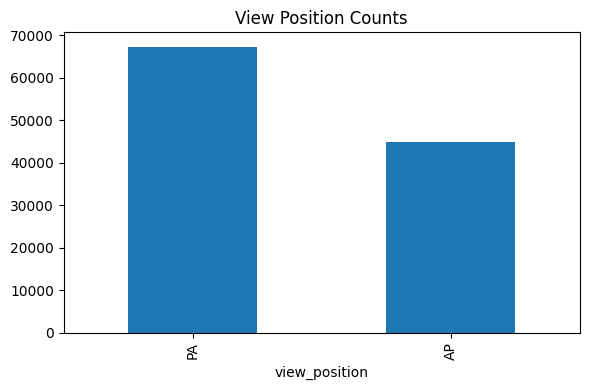

In [26]:

plt.figure(figsize=(6,4))
vp.plot(kind="bar")
plt.title("View Position Counts")
plt.tight_layout()
plt.show()


## 9) Labels-per-image distribution

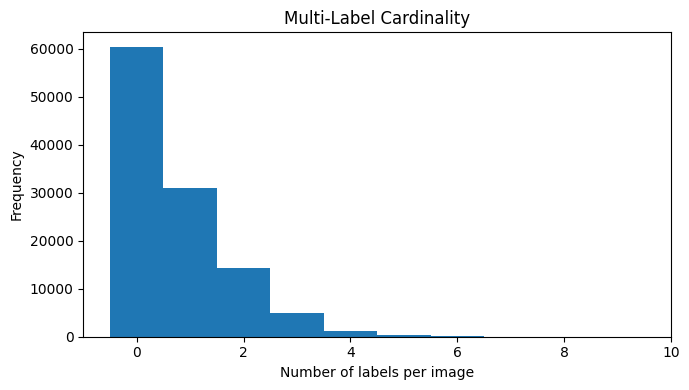

In [27]:

plt.figure(figsize=(7,4))
bins = range(0, int(df["label_count"].max()) + 2)
df["label_count"].plot(kind="hist", bins=bins, align="left")
plt.xlabel("Number of labels per image")
plt.title("Multi-Label Cardinality")
plt.tight_layout()
plt.show()


## 10) Quick summary

In [28]:

summary = {
    "rows": len(df),
    "unique_images": df["image_index"].nunique(),
    "unique_patients": df["patient_id"].nunique(),
    "pct_missing_age": float(df["patient_age"].isna().mean() * 100),
    "pct_missing_gender": float(df["patient_gender"].isna().mean() * 100),
    "pct_missing_view": float(df["view_position"].isna().mean() * 100),
}
pd.DataFrame([summary])


,rows,unique_images,unique_patients,pct_missing_age,pct_missing_gender,pct_missing_view
0,112120,112120,30805,0.01427,0.0,0.0
